## Домашнее задание 2
### Линейные модели
---


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

#### Задание 1 (Теоретическое)
На лекции было сказано, что большие по модулю веса могут сигнализировать о наличии переобучения или о наличии линейной зависимости между признаками. В этом задании вам предстоит показать, что при отсутствии регуляризации (штрафа за большие веса) коэффициенты перед зависимыми признаками могут расти неограниченно.

Рассмотрим данные, в которых истинная зависимость целевой переменной $y$ от признака $x$ описывается коэффициентом w (то есть истинная зависимость выглядит как $y = wx + ...$, где ... - другие признаки НЕ ЗАВИСЯЩИЕ от x). Искусственно добавим в модель зависимый признак равный -x. 
После обучения модели получим зависимость $y = w_1x + w_2 (-x) + ...$.

Покажите, что веса $w_1$ и $w_2$ могут быть сколь угодно большими.

$y = w_1x + w_2 (-x) + ... = x(w_1 - w_2) + ... = x((w_1 + a) - (w_2 + a)) + ... $

К $w_1$ и $w_2$ можно добавить любое константное слагаемое. Оно не повлияет на результат и при этом может быть сколько угодно большим

#### Задание 2

Линейная регрессия с L2-регуляризацией или Ridge регрессия состоит в минимизации следующего функционала:
$$||Y - Xw||^2 + \lambda ||w||^2 \rightarrow min$$

Для данной задачи можно выписать явное решение:
$$w = (X^TX + \lambda I)^{-1}X^TY$$

Реализуйте свой класс для гребневой регрессии, воспользовавшись формулой выше.

In [3]:
class MyRidgeRegression:
    
    def __init__(self, alpha=1.0):
        self.alpha = alpha
    
    def fit(self, X, y):
        # Принимает на вход X, y и вычисляет веса по данной выборке
        # Не забудьте про фиктивный признак равный 1!
        # Не применяйте регуляризацию к параметру b
        
        # ВАШ КОД ЗДЕСЬ
        a = np.ones((X.shape[0], 1))
        X = np.concatenate((X, a), axis=1)
        self.w = np.linalg.inv(X.T@X + self.alpha*np.eye(X.shape[1]))@X.T@y
        
    def predict(self, X):
        # Принимает на вход X и возвращает ответы модели
        # ВАШ КОД ЗДЕСЬ
        a = np.ones((X.shape[0], 1))
        X = np.concatenate((X, a), axis=1)
        y_pred = X@self.w
        return y_pred
    
    def get_weights(self):
        return self.w

Протестируем наш алгоритм на искусственных данных и сравним с линейной регрессией без регуляризации

In [4]:
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=100)

In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [8]:
linear_regr = LinearRegression()
ridge_regr = MyRidgeRegression(alpha=0.1)

linear_regr.fit(X_train, y_train)
ridge_regr.fit(X_train, y_train)

linear_regr_predictions = linear_regr.predict(X_test)
ridge_regr_predictions = ridge_regr.predict(X_test)

В качестве метрики качества воспользуемся MAE (средняя абсолютная ошибка)

In [9]:
from sklearn.metrics import mean_absolute_error

In [10]:
print('Linear regression: ', mean_absolute_error(y_test, linear_regr_predictions))

Linear regression:  134.97450418682794


In [11]:
print('Ridge regression: ', mean_absolute_error(y_test, ridge_regr_predictions))

Ridge regression:  135.55934096901333


Попробуйте подобрать такой коэффициент регуляризации, чтобы ошибка на тесте была меньше, чем у модели без регуляризации.

In [12]:
mae = []

for alpha in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    linear_regr = LinearRegression()
    ridge_regr = MyRidgeRegression(alpha=alpha)

    linear_regr.fit(X_train, y_train)
    ridge_regr.fit(X_train, y_train)

    linear_regr_predictions = linear_regr.predict(X_test)
    ridge_regr_predictions = ridge_regr.predict(X_test)

    mae.append((alpha, mean_absolute_error(y_test, ridge_regr_predictions)))

In [13]:
pd.DataFrame(mae, columns=['alpha', 'mae'])

,alpha,mae
0,100.0000,137.788721
1,10.0000,133.963268
2,1.0000,135.257576
3,0.1000,135.559341
4,0.0100,135.591255
5,0.0010,135.594465
6,0.0001,135.594786


При коэффициенте регуляризации 1 и меньше ошибка на тесте меньше, чем у модели без регуляризации

#### Задание 3
В этом задании предлагается поиграться с различными ядрами SVM и подобрать лучшие параметры для каждого из них

Вам дан датасет (находится в файле banknote.data), в котором представлены различные статистики подсчитанные для изображения купюр. Задача состоит в классификации купюр на подлинные и фальшивые на основе этих данных.
(Подробнее https://archive.ics.uci.edu/ml/datasets/banknote+authentication)

,V1,V2,V3,V4,Class
0,3.62160,8.6661,-2.8073,-0.44699,1
1,4.54590,8.1674,-2.4586,-1.46210,1
2,3.86600,-2.6383,1.9242,0.10645,1
3,3.45660,9.5228,-4.0112,-3.59440,1
4,0.32924,-4.4552,4.5718,-0.98880,1


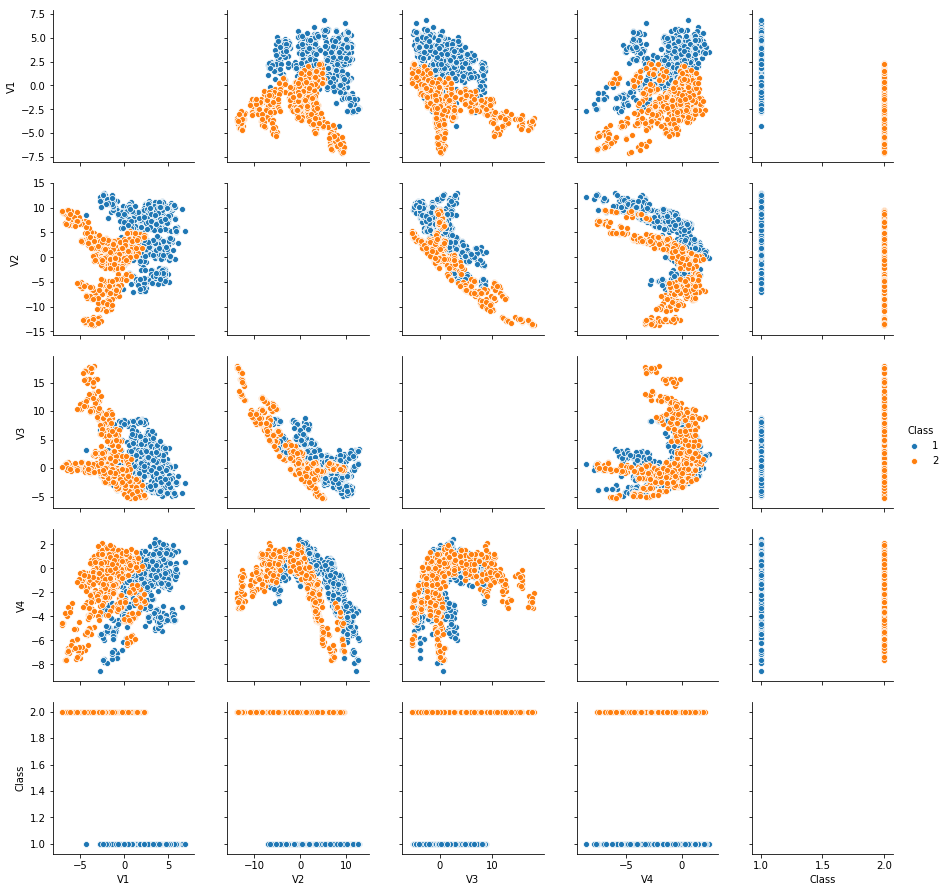

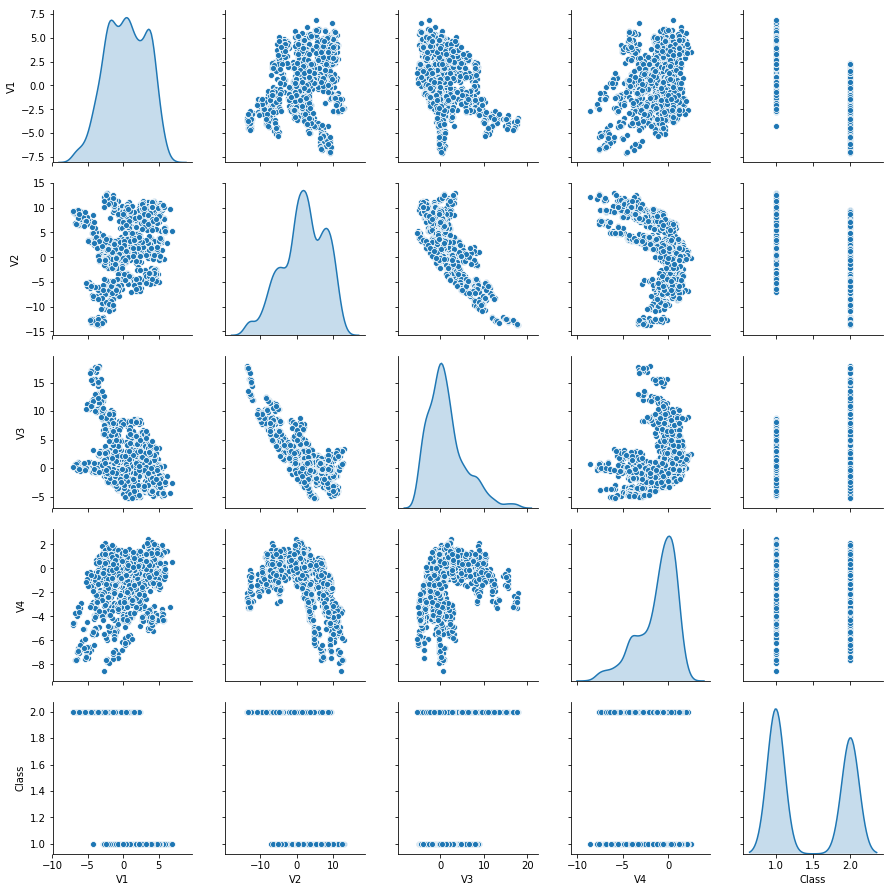

In [14]:
import seaborn as sns

# data = pd.read_csv('banknote.data', sep=',', header=-1)
data = pd.read_csv('https://datahub.io/machine-learning/banknote-authentication/r/banknote-authentication.csv')
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# одновременно нарисовать график и цветной и с распределениями не получается (особенность датасета)
sns.pairplot(data, diag_kind='', hue='Class')
sns.pairplot(data, diag_kind='kde')

data.head()

Разделите выборку на трейн и тест в соотношении 1:1

In [15]:
# ВАШ КОД ЗДЕСЬ
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [16]:
from sklearn.svm import SVC

Для каждого из ядер svc (параметр kernel='linear', 'poly', 'rbf') постарайтесь подобрать наилучший набор параметров, который максимизирует метрику F1-score на тесте. 

НАПОМИНАНИЕ: $ F1 = 2\frac{precision \cdot recall}{precision + recall} $

ПОДСКАЗКА: параметр C в SVC отвечает за коэффициент регуляризации, degree - степень полинома в полиномиальном ядре, gamma - коэффициент в экспоненте у гауссовского ядра. Про другие парамеры (если понадобятся) предлагается прочитать самостоятельно.

In [17]:
from sklearn.metrics import f1_score, make_scorer

In [18]:
from sklearn.model_selection import ParameterGrid

In [19]:
# ВАШ КОД ЗДЕСЬ
score = []
grid = ParameterGrid([{'kernel': ['linear'], 'C':[0.1, 0.25, 0.5, 0.75, 1, 10]}, 
                      {'kernel': ['rbf'], 'gamma': [0.1, 1, 10, 100], 'C':[0.1, 0.25, 0.5, 0.75, 1, 10]},
                      {'kernel': ['poly'], 'degree': [2, 3, 4, 5], 'C':[0.1, 0.25, 0.5, 0.75, 1, 10]}])
for params in grid:
    svc = SVC(**params)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    score.append((params, f1_score(y_test, y_pred)))

In [20]:
score_df = pd.DataFrame(score, columns=['params', 'f1'])
score_df.sort_values('f1', ascending=False)

,params,f1
14,"{'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}",1.000000
10,"{'C': 0.25, 'gamma': 0.1, 'kernel': 'rbf'}",1.000000
27,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}",0.998658
23,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}",0.998658
19,"{'C': 0.75, 'gamma': 1, 'kernel': 'rbf'}",0.998658
26,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.998654
22,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",0.998654
18,"{'C': 0.75, 'gamma': 0.1, 'kernel': 'rbf'}",0.998654
15,"{'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}",0.997319
6,"{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}",0.995951


#### БОНУС

Предлагаю немного расслабиться и посмотреть как делается полиномиальная регрессия (добавление степенных признаков в модель) и как Lasso проводит отбор признаков.

D:\Anaconda\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
D:\Anaconda\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


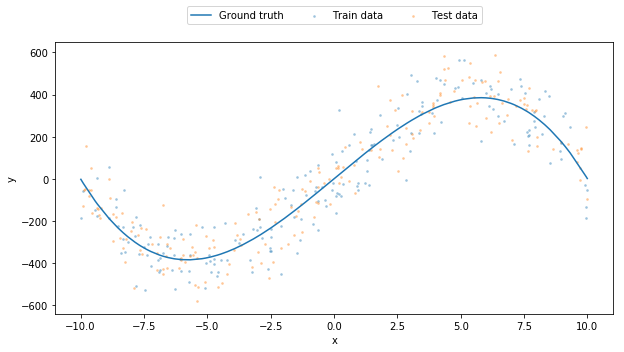

In [21]:
# Data generation

def gen_batch(n, w, beta):
    d = len(w)
    X = np.random.uniform(-10, 10, (n, 1))
    X = np.sort(X, axis=0)
    X = np.hstack([X ** i for i in range(d)])
    t = X.dot(w) + np.random.normal(size=n) / beta ** 0.5
    return X, t

n = 200
d = 21
w_true = np.zeros(d)
w_true[1] = 100
w_true[3] = -1
beta_true = 1e-4

X_train, t_train = gen_batch(n, w_true, beta_true)
X_test, t_test = gen_batch(n, w_true, beta_true)

# Visualization
plt.figure(figsize=(10, 5))
plt.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
plt.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [22]:
# Ridge Regression with Cross-Validation
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(cv=20, alphas=10.**np.arange(-6, 3, 1),
                fit_intercept=False)
ridge.fit(X_train, t_train)
w_ridge = ridge.coef_

In [23]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV, Lasso
lasso = LassoCV(cv=20, alphas=10.**np.arange(-6, 3, 1),
                fit_intercept=False)
lasso.fit(X_train, t_train)
w_lasso = lasso.coef_

D:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2022697.149967824, tolerance: 1707.045579610936
  tol, rng, random, positive)
D:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1191135.9462575857, tolerance: 1707.045579610936
  tol, rng, random, positive)
D:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1027997.6013208425, tolerance: 1707.045579610936
  tol, rng, random, positive)
D:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

D:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 988557.4946975295, tolerance: 1710.576791465026
  tol, rng, random, positive)
D:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2072082.1373120209, tolerance: 1718.7103699446966
  tol, rng, random, positive)
D:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1197930.6468888954, tolerance: 1718.7103699446966
  tol, rng, random, positive)
D:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dua

Ridge Regression
Features remaining: 21 / 21
Train error: 10232.91054457314
Test error:  9541.429245126785
--------------------------------------------------
Lasso Regression
Features remaining: 16 / 21
Train error: 10629.935786374139
Test error:  9495.03242251985


D:\Anaconda\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
D:\Anaconda\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


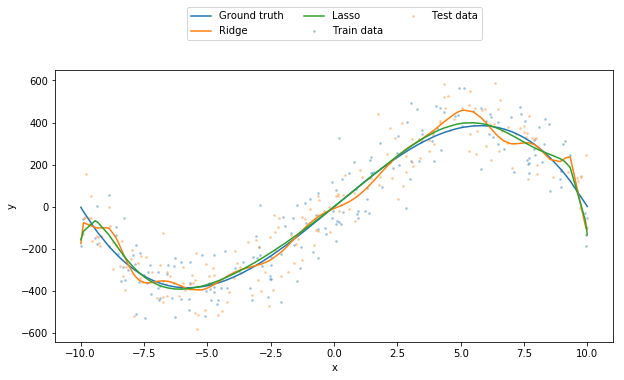

In [24]:
def l2_error(X, t, w):
    return np.sum((X.dot(w.ravel()) - t) ** 2)

# Comparison
print('Ridge Regression')
print('Features remaining:', np.sum(np.abs(w_ridge) > 1e-15), '/', d)
print('Train error:', l2_error(X_train, t_train, w_ridge) / n)
print('Test error: ', l2_error(X_test, t_test, w_ridge) / n)
print('-'*50)
print('Lasso Regression')
print('Features remaining:', np.sum(np.abs(w_lasso) > 1e-15), '/', d)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)

plt.figure(figsize=(10, 5))
plt.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
plt.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')
plt.plot(X_train[:, 1], X_train.dot(w_ridge), label='Ridge')
plt.plot(X_train[:, 1], X_train.dot(w_lasso), label='Lasso')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()